In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/01_Strains_AMLNtoControl_Kupffer_RNA/'
amlnDirectory = '/home/h1bennet/strains/data/RNA/AMLN_30week_kupffer/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./figures/'):
    os.mkdir('././figures/')

In [3]:
tpm = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                  index_col=0,
                  sep='\t')

In [4]:
groups = [[0,1],
          [6,7,8,9],
          [2,3],
          [10,11,12],
          [4,5],
          [13,14,15,16]]

group_labels = ['AJ LSEC Control young',
                'AJ LSEC AMLN 30 weeks',
                'Balb/cJ LSEC Control young',
                'Balb/cJ LSEC AMLN 30 weeks',
                'C57BL/6J LSEC Control young',
                'C57BL/6J LSEC AMLN 30 weeks']

colors = ['#de2d26',
          '#a50f15',
          '#6baed6',
          '#08519c',
          '#74c476',
          '#006d2c']

In [7]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

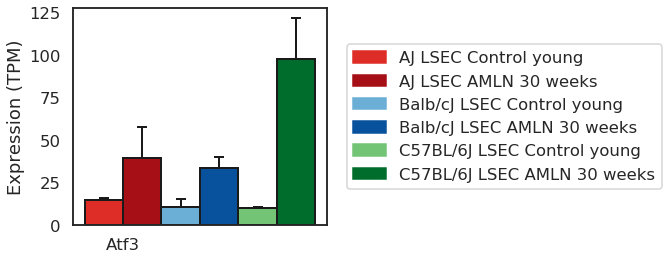

In [11]:
gene = 'Atf3'

fig, axs = plt.subplots(1, 2,
                       figsize=(10, 4))

gene_list_bar_plot([gene],
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

In [ ]:
makeMultiWigHub.pl hrb_strains_viz_atac_merged_young_control mm10 \
-color 252,146,114 158,202,225 161,217,155 \
-force -d \
./merged_tagdirs/02_aj_Kupffer_ATAC_young_control/ \
./merged_tagdirs/01_balbc_Kupffer_ATAC_young_control/ \
./merged_tagdirs/00_C57_Kupffer_ATAC_young_control/